# processing files for a given large ensemble

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import xcdat as xc
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

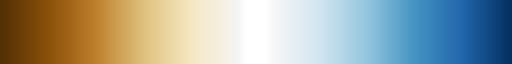

In [4]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [5]:
import os

In [6]:
import climtas
from scipy import stats
# import seaborn as sns
import pandas as pd
from dateutil.relativedelta import relativedelta
import regionmask

def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def reorder(da):
    da['time'] = pd.date_range('1900-01-01', '2015-01-01', freq='1M')

    custom = da.sel(time=da.time.dt.month.isin([6,7,8,9,10,11,12,1,2,3,4,5]))
    # convert cftime to datetime
    datetimeindex = custom.indexes['time']#.to_datetimeindex() 
    # custom['time'] = pd.to_datetime(datetimeindex)
    
    # Add custom group by year functionality
    custom_year = custom['time'].dt.year
    
    # convert time type to pd.Timestamp
    time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    # time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    
    # Add year to Timestamp objects when month is before Jan. (relativedelta does not work from np.datetime64)
    time2 = [i + relativedelta(years=1) if i.month>=6 else i for i in time1] 
    custom['time'] = time2
    return custom

####


def calc_anom(
    input_da,
    base_start_date: str = "1960-01-01",
    base_end_date: str = "1990-01-01",
    start_year: str = "1900-01-01",
    end_year: str = "2015-01-01",
    # var = "Temperature",
    # units = 'K'
):

    # define the base climatology
    base_clim = input_da.sel(time=slice(base_start_date, base_end_date))

    # calculate the monthly climatology for the base years
#     da_clim_coarsen = base_clim.coarsen(time=12)
    da_clim = base_clim.groupby("time.month").mean("time")
    da_anom = input_da.sel(time = slice(start_year, end_year)).groupby("time.month") - da_clim
    
    return da_anom

####

In [7]:
# Function to preprocess the regridded data


import xarray as xr
from statsmodels.tsa.seasonal import STL
import pymannkendall as mk

def detrend1d(arr, period = 9*12):
    res = STL(arr, period = period).fit()
    arr_det = arr - res.trend
    return arr_det
    
def detrend1d_check(arr, period = 9):
    # if np.nansum(arr) != 0:
    #     trend = mk.hamed_rao_modification_test(arr).trend
    # else:
    #     trend = 'no trend'
    # if trend != 'no trend':
    #     res = STL(arr, period = period).fit()
    #     arr_det = arr - res.trend
    #     return arr_det
    # else:
    #     return arr
    res = STL(arr, period = period).fit()
    arr_det = arr - res.trend
    return arr_det

# def detrend_separate(da, period=9):
#     trend = da.rolling(time = period*12).mean('time')
#     da_detrend = da - trend
#     return da_detrend
def detrend_separate(da, dim):
    return xr.apply_ufunc(detrend1d, da, input_core_dims=[[dim]], output_core_dims=[[dim]])
    
def detrend_separate_check(da, dim):
    return xr.apply_ufunc(detrend1d_check, da, input_core_dims=[[dim]], output_core_dims=[[dim]])

In [8]:
def extract_results_parallel(var, nino34, dmi):
    weights = np.cos(np.deg2rad(var.lat))
    weights.name = 'weights'
    # reorder the vars
    var = var.weighted(weights).mean(('lat', 'lon'))
    return var.to_numpy(), nino34.to_numpy(), dmi.to_numpy()


def calc_data_res_parallel(params, mod_name):
    # base_loc = '/scratch/ob22/as8561/data/preproc/'
    base_loc = f'/g/data/ob22/as8561/data/preproc_files/{mod_name}/'
    variant = params[0]
    region = params[1]
    # get all the data
    precip = xr.open_dataset(base_loc + f'{variant}/precip.nc').precip.sel(time = slice('1900', '2015'))#.load()
    precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
    precip = precip.sortby(precip.lon)
    #
    nino34 = xr.open_dataset(base_loc + f'{variant}/nino.nc').nino.sel(time = slice('1900', '2015'))#.load()
    dmi = xr.open_dataset(base_loc + f'{variant}/dmi.nc').dmi.sel(time = slice('1900', '2015'))#.load()
    # mask the land area firt
    land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(precip, wrap_lon=False, drop=False)
    precip_land = precip.where(land_mask.isel(region=0))
    # mask for the ar6 land regions
    ar6_mask = regionmask.defined_regions.ar6.land.mask_3D(precip_land, wrap_lon=False, drop=False)
    # ar6_list = regionmask.defined_regions.ar6.land.to_dataframe()['names'].to_numpy()
    out_precip, out_nino, out_dmi = extract_results_parallel(precip_land.where(ar6_mask.isel(region=region)), nino34, dmi)
    return out_precip, out_nino, out_dmi

In [9]:
from multiprocessing import Pool
import itertools

In [10]:
region_list = regionmask.defined_regions.ar6.land.to_dataframe().index.to_numpy()

In [11]:
#   change mod_name here
mod_name = 'CESM2'
test = pd.read_csv(f'./data/model/{mod_name}_pr.csv')
variant_list = test.dropna()['variant_label'].to_numpy()
variant_list

array(['r10i1p1f1', 'r11i1p1f1', 'r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1',
       'r4i1p1f1', 'r5i1p1f1', 'r6i1p1f1', 'r7i1p1f1', 'r8i1p1f1',
       'r9i1p1f1'], dtype=object)

In [12]:
param_arr = [variant_list[:-1], region_list]

In [13]:
param_list = list(itertools.product(*param_arr))

In [15]:
param_list

[('r10i1p1f1', 0),
 ('r10i1p1f1', 1),
 ('r10i1p1f1', 2),
 ('r10i1p1f1', 3),
 ('r10i1p1f1', 4),
 ('r10i1p1f1', 5),
 ('r10i1p1f1', 6),
 ('r10i1p1f1', 7),
 ('r10i1p1f1', 8),
 ('r10i1p1f1', 9),
 ('r10i1p1f1', 10),
 ('r10i1p1f1', 11),
 ('r10i1p1f1', 12),
 ('r10i1p1f1', 13),
 ('r10i1p1f1', 14),
 ('r10i1p1f1', 15),
 ('r10i1p1f1', 16),
 ('r10i1p1f1', 17),
 ('r10i1p1f1', 18),
 ('r10i1p1f1', 19),
 ('r10i1p1f1', 20),
 ('r10i1p1f1', 21),
 ('r10i1p1f1', 22),
 ('r10i1p1f1', 23),
 ('r10i1p1f1', 24),
 ('r10i1p1f1', 25),
 ('r10i1p1f1', 26),
 ('r10i1p1f1', 27),
 ('r10i1p1f1', 28),
 ('r10i1p1f1', 29),
 ('r10i1p1f1', 30),
 ('r10i1p1f1', 31),
 ('r10i1p1f1', 32),
 ('r10i1p1f1', 33),
 ('r10i1p1f1', 34),
 ('r10i1p1f1', 35),
 ('r10i1p1f1', 36),
 ('r10i1p1f1', 37),
 ('r10i1p1f1', 38),
 ('r10i1p1f1', 39),
 ('r10i1p1f1', 40),
 ('r10i1p1f1', 41),
 ('r10i1p1f1', 42),
 ('r10i1p1f1', 43),
 ('r10i1p1f1', 44),
 ('r10i1p1f1', 45),
 ('r11i1p1f1', 0),
 ('r11i1p1f1', 1),
 ('r11i1p1f1', 2),
 ('r11i1p1f1', 3),
 ('r11i1p1f1',

In [18]:
name_list = ['precip', 'nino', 'dmi']

In [19]:
time = xr.open_dataset(f'/g/data/ob22/as8561/data/preproc_files/{mod_name}/r10i1p1f1/precip.nc').sel(time = slice('1900', '2015')).time.to_numpy()
time

In [ ]:
def convert_to_da(arr, name):
    return xr.DataArray(
        data = arr,
        dims = ["time", "region", "model"],
        coords = dict(
            time = (["time"], time),
            region = (["region"], region_list),
            model = (["model"], variant_list),
        ),
        name = name
    )

# def convert_to_da_base(arr, name):
#     return xr.DataArray(
#         data = arr,
#         dims = ["season", "region", "model"],
#         coords = dict(
#             season = (["season"], ['djf', 'jja', 'mam', 'son']),
#             region = (["region"], region_list),
#             model = (["model"], model_list),
#         ),
#         name = name
#     )

In [16]:
from functools import partial

In [17]:
mod_name

'CESM2'

In [4]:
res_arr = []
with Pool() as pool:
    i = 0
    for res in pool.imap(partial(calc_data_res_parallel, mod_name = mod_name), param_list):
        res_arr.append(res)
        print(f'completed {i+1}/{len(variant_list)*len(region_list)}', end='\r')
        i += 1

NameError: name 'Pool' is not defined

In [ ]:
# res_arr = np.array(res_arr)
da_arr = []
precip_arr = np.empty((1380, len(variant_list)*len(region_list)))
nino_arr = np.empty((1380, len(variant_list)*len(region_list)))
dmi_arr = np.empty((1380, len(variant_list)*len(region_list)))
# base_arr = np.empty((4, 1472))

for i in range(len(variant_list)*len(region_list)):
    precip_arr[:, i] = np.array(res_arr)[:, 0][i]
    nino_arr[:, i] = np.array(res_arr)[:, 1][i]
    dmi_arr[:, i] = np.array(res_arr)[:, 2][i]
    # base_arr[:, i] = np.array(res_arr)[:, 2][i]
    
da_precip = convert_to_da(np.reshape(precip_arr, (1380, len(region_list), len(variant_list)), order = 'F'), name_list[0])
da_nino = convert_to_da(np.reshape(nino_arr, (1380, len(region_list), len(variant_list)), order = 'F'), name_list[1])
da_dmi = convert_to_da(np.reshape(dmi_arr, (1380, len(region_list), len(variant_list)), order = 'F'), name_list[2])
# da_base = convert_to_da_base(np.reshape(base_arr, (4, 46, 32), order = 'F'), name_list[2])

In [ ]:
ds=xr.merge([da_precip, da_nino, da_dmi])

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 1380, region: 46, model: 66)
Coordinates:
  * time     (time) object 1900-01-16 12:00:00 ... 2014-12-16 12:00:00
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * model    (model) object 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p1f1' 'r9i1p2f1'
Data variables:
    precip   (time, region, model) float64 21.05 21.31 23.89 ... 19.37 24.74
    nino     (time, region, model) float64 nan nan nan ... -0.3999 0.6011 -2.503
    dmi      (time, region, model) float64 -0.1894 0.08869 ... 1.481 -0.4923

In [ ]:
ds.to_netcdf('./data/result/raw_cesm2_le.nc')

In [ ]:
def calc_res(precip, nino34, season_str):
    precip_anom = calc_anom(precip)
    threshold = float(nino34.std())
    # nino34 = reorder(nino34).sel(time = sondjf).groupby('time.year').mean('time')[:-1]
    if season_str == 'ANN':
        precip_clim = float(reorder(precip).groupby('time.year').mean('time').mean('year'))
        precip_std = float(reorder(precip).groupby('time.year').mean('time').std('year'))
        precip_det = detrend_separate_check(reorder(precip_anom).groupby('time.year').mean('time'), dim='year').sel(year = slice('1900', '2015'))
        nino34 = reorder(nino34).groupby('time.year').mean('time').sel(year = slice('1900', '2015'))
        pr_skw = float(stats.skew(precip_det/precip_std))
        n34_skw = float(stats.skew(nino34))
        en_events = float(nino34.where(nino34 > threshold).count())
        ln_events = float(nino34.where(nino34 < -threshold).count())
        neut_events = float(nino34.where((nino34 < 0.5*threshold) & (nino34 > -0.5*threshold)).count())
        corr = float(get_corr(nino34, precip_det, 'year'))
        pval = float(get_pval(nino34, precip_det, 'year'))
        nino = float(precip_det.where(nino34 > threshold).mean('year'))/precip_std
        nina = float(precip_det.where(nino34 < -threshold).mean('year'))/precip_std
        neut = float(precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold)).mean('year'))/precip_std
        enc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 > threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        lnc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 < -threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        enc = nino - neut
        lnc = nina - neut
        asymm = (enc + lnc)/2
    else:
        season_names = ['DJF', 'MAM', 'JJA', 'SON']
        season_months = [[12,1,2], [3,4,5], [6,7,8], [9,10,11]]
        season_dict = dict(zip(season_names, season_months))
        season_month = season_dict[season_str]
        season = precip_anom.time.dt.month.isin(season_month)
        precip_clim = float(precip.groupby('time.season').mean('time').sel(season = season_str))
        precip_std = float(precip.groupby('time.season').std('time').sel(season = season_str))
        if season_str == 'DJF':
            precip_det = detrend_separate_check(reorder(precip_anom).sel(time = season).groupby('time.year').mean('time'), dim='year').sel(year = slice('1901', '2015'))
            nino34 = reorder(nino34).sel(time = season).groupby('time.year').mean('time').sel(year = slice('1901', '2015'))
        else:
            precip_det = detrend_separate_check(precip_anom.sel(time = season).groupby('time.year').mean('time'), dim='year').sel(year = slice('1900', '2015'))
            nino34 = nino34.sel(time = season).groupby('time.year').mean('time').sel(year = slice('1900', '2015'))
        pr_skw = float(stats.skew(precip_det/precip_std))
        n34_skw = float(stats.skew(nino34))
        en_events = float(nino34.where(nino34 > threshold).count())
        ln_events = float(nino34.where(nino34 < -threshold).count())
        neut_events = float(nino34.where((nino34 < 0.5*threshold) & (nino34 > -0.5*threshold)).count())
        corr = float(get_corr(nino34, precip_det, 'year'))
        pval = float(get_pval(nino34, precip_det, 'year'))
        nino = float(precip_det.where(nino34 > threshold).mean('year'))/precip_std
        nina = float(precip_det.where(nino34 < -threshold).mean('year'))/precip_std
        neut = float(precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold)).mean('year'))/precip_std
        enc = nino - neut
        lnc = nina - neut
        try:
            enc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 > threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        except ValueError:
            enc_pval = np.NaN
            nino = 0
            enc = 0
        try:
            lnc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 < -threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        except ValueError:
            lnc_pval = np.NaN
            nina = 0
            lnc = 0
        asymm = (enc + lnc)/2
    return dict(
        precip_clim = precip_clim,
        precip_std = precip_std,
        pr_skw = pr_skw,
        n34_skw = n34_skw,
        corr = corr,
        pval = pval,
        nino = nino,
        nina = nina,
        neut = neut,
        enc_pval = enc_pval,
        lnc_pval = lnc_pval,
        enc = enc,
        lnc = lnc,
        asymm = asymm,
        threshold = threshold,
        en_events = en_events,
        ln_events = ln_events,
        neut_events  = neut_events
    )

In [ ]:
raw_cesm2 = xr.open_dataset('./data/result/raw_cesm2_le.nc')

In [ ]:
naus  = raw_canesm5.isel(region=39, model = 10)
naus

<xarray.Dataset>
Dimensions:  (time: 1380)
Coordinates:
  * time     (time) object 1900-01-16 12:00:00 ... 2014-12-16 12:00:00
    region   int64 39
    model    <U9 'r15i1p1f1'
Data variables:
    precip   (time) float64 ...
    nino     (time) float64 ...
    dmi      (time) float64 ...

In [ ]:
res = calc_res(naus.precip, naus.nino, season_str='SON')
res

{'precip_clim': 22.518647083550388,
 'precip_std': 27.30885487961186,
 'pr_skw': 1.6058298436493486,
 'n34_skw': -0.002099841707907795,
 'corr': -0.44971198611220714,
 'pval': 4.607325761446174e-07,
 'nino': -0.39361325941624703,
 'nina': 0.3381603986344926,
 'neut': -0.0018967849405678076,
 'enc_pval': 0.0007829382178911192,
 'lnc_pval': 0.054742572136765096,
 'enc': -0.3917164744756792,
 'lnc': 0.34005718357506043,
 'asymm': -0.025829645450309385,
 'threshold': 0.6453586301809128,
 'en_events': 16.0,
 'ln_events': 22.0,
 'neut_events': 34.0}

In [ ]:
ar6_list = regionmask.defined_regions.ar6.land.to_dataframe().names.to_numpy()
season_list = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']

In [ ]:
std = np.empty((len(variant_list), len(ar6_list), len(season_list)))
clim = np.empty((len(variant_list), len(ar6_list), len(season_list)))
pr_skw = np.empty((len(variant_list), len(ar6_list), len(season_list)))
n34_skw = np.empty((len(variant_list), len(ar6_list), len(season_list)))
corr = np.empty((len(variant_list), len(ar6_list), len(season_list)))
pval = np.empty((len(variant_list), len(ar6_list), len(season_list)))
nino = np.empty((len(variant_list), len(ar6_list), len(season_list)))
nina = np.empty((len(variant_list), len(ar6_list), len(season_list)))
neut = np.empty((len(variant_list), len(ar6_list), len(season_list)))
enc_pval = np.empty((len(variant_list), len(ar6_list), len(season_list)))
lnc_pval = np.empty((len(variant_list), len(ar6_list), len(season_list)))
threshold = np.empty((len(variant_list)))
en_events = np.empty((len(variant_list), len(season_list)))
ln_events = np.empty((len(variant_list), len(season_list)))
neut_events = np.empty((len(variant_list), len(season_list)))
for i in range(len(variant_list)):
    for j in range(len(ar6_list)):
        for k in range(len(season_list)):
            precip = raw_cesm2.precip.isel(model=i, region=j)
            nino34 = raw_cesm2.nino.isel(model = i, region=j)
            res = calc_res(precip, nino34, season_str=season_list[k])
            std[i, j, k] = res['precip_std']
            clim[i, j, k] = res['precip_clim']
            pr_skw[i, j, k] = res['pr_skw']
            n34_skw[i, j, k] = res['n34_skw']
            corr[i, j, k] = res['corr']
            pval[i, j, k] = res['pval']
            nino[i, j, k] = res['nino']
            nina[i, j, k] = res['nina']
            neut[i, j, k] = res['neut']
            enc_pval[i, j, k] = res['enc_pval']
            lnc_pval[i, j, k] = res['lnc_pval']
            en_events[i, k] = res['en_events']
            ln_events[i, k] = res['ln_events']
            neut_events[i, k] = res['neut_events']
    threshold[i] = res['threshold']
    print(f'Completed variant {i+1}/{len(variant_list)}')
print('COMPLETE')

Completed variant 1/66
Completed variant 2/66
Completed variant 3/66
Completed variant 4/66
Completed variant 5/66
Completed variant 6/66
Completed variant 7/66
Completed variant 8/66
Completed variant 9/66
Completed variant 10/66
Completed variant 11/66
Completed variant 12/66
Completed variant 13/66
Completed variant 14/66
Completed variant 15/66
Completed variant 16/66
Completed variant 17/66
Completed variant 18/66
Completed variant 19/66
Completed variant 20/66
Completed variant 21/66
Completed variant 22/66
Completed variant 23/66
Completed variant 24/66
Completed variant 25/66
Completed variant 26/66
Completed variant 27/66
Completed variant 28/66
Completed variant 29/66
Completed variant 30/66
Completed variant 31/66
Completed variant 32/66
Completed variant 33/66
Completed variant 34/66
Completed variant 35/66
Completed variant 36/66
Completed variant 37/66
Completed variant 38/66
Completed variant 39/66
Completed variant 40/66
Completed variant 41/66
Completed variant 42/66
C

In [25]:
main_ds = xr.Dataset(
    data_vars=dict(
        std_dev = (["model", "region", "season"], std),
        clim = (["model", "region", "season"], clim),
        pr_skw = (["model", "region", "season"], pr_skw),
        n34_skw = (["model", "region", "season"], n34_skw),
        corr_coef = (["model", "region", "season"], corr),
        pval = (["model", "region", "season"], pval),
        nino = (["model", "region", "season"], nino),
        nina = (["model", "region", "season"], nina),
        neut = (["model", "region", "season"], neut),
        enc_pval = (["model", "region", "season"], enc_pval),
        lnc_pval = (["model", "region", "season"], lnc_pval),
        en_events = (["model", "season"], en_events),
        ln_events = (["model", "season"], ln_events),
        neut_events = (["model", "season"], neut_events),
        threshold = (["model"], threshold)
    ),
    coords=dict(
        model=(["model"], variant_list),
        region=(["region"], ar6_list),
        season=(["season"], season_list)
    )
)

In [26]:
main_ds.to_netcdf('./data/result/out_canesm5_le.nc')

### general analysis

In [27]:
out_canesm5_le = xr.open_dataset('./data/result/out_canesm5_le.nc')

In [28]:
out_canesm5_le['enc'] = out_canesm5_le.nino - out_canesm5_le.neut
out_canesm5_le['lnc'] = out_canesm5_le.nina - out_canesm5_le.neut
out_canesm5_le['asymm'] = (out_canesm5_le.enc + out_canesm5_le.lnc)/2
out_canesm5_le['symm'] = (out_canesm5_le.enc - out_canesm5_le.lnc)/2

In [29]:
out_canesm5_le['asymm_pval'] = xr.where((out_canesm5_le.enc_pval > 0.05) & (out_canesm5_le.lnc_pval > 0.05), 0, 1)

In [30]:
out_canesm5_le

<xarray.Dataset>
Dimensions:      (model: 66, region: 46, season: 5)
Coordinates:
  * model        (model) object 'r10i1p1f1' 'r10i1p2f1' ... 'r9i1p2f1'
  * region       (region) object 'Greenland/Iceland' ... 'W.Antarctica'
  * season       (season) object 'ANN' 'DJF' 'MAM' 'JJA' 'SON'
Data variables: (12/20)
    std_dev      (model, region, season) float64 ...
    clim         (model, region, season) float64 ...
    pr_skw       (model, region, season) float64 ...
    n34_skw      (model, region, season) float64 ...
    corr_coef    (model, region, season) float64 ...
    pval         (model, region, season) float64 ...
    ...           ...
    threshold    (model) float64 ...
    enc          (model, region, season) float64 0.2445 -0.4117 ... -0.07143
    lnc          (model, region, season) float64 -0.213 -0.1176 ... 0.02567
    asymm        (model, region, season) float64 0.01576 -0.2646 ... -0.02288
    symm         (model, region, season) float64 0.2287 -0.1471 ... -0.04855
    asymm_pval   (model, region, season) int64 0 1 0 1 0 0 1 1 ... 0 0 0 1 0 0 0

In [31]:
import seaborn as sns

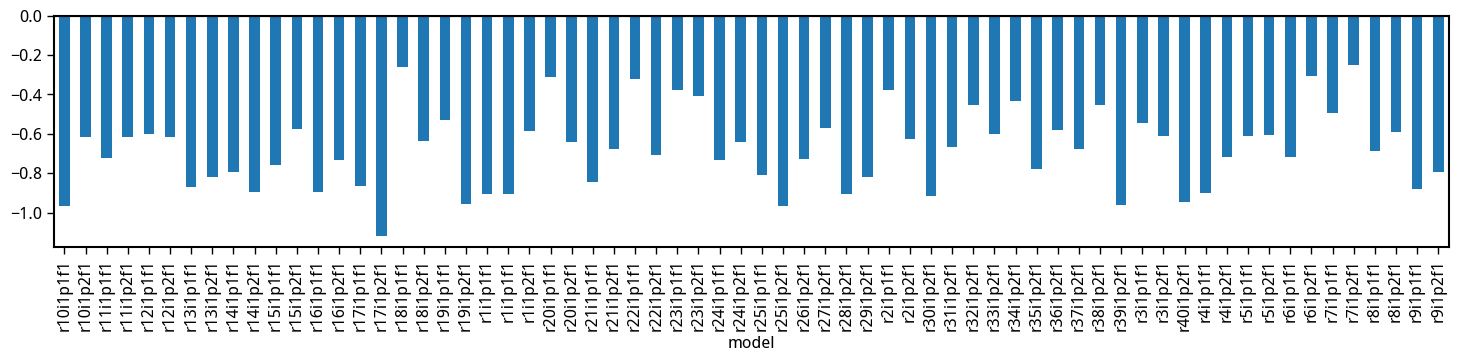

In [32]:
plt.figure(figsize=(18,3))
out_canesm5_le.enc.isel(season=0, region=41).to_series().plot.bar()#.to_dataframe().pivot_table(values='asymm', columns='model', index='region'), cmap='BrBG')
plt.xticks(rotation=90)
# plt.ylim(-0.5, 0.5)
plt.axhline(0.0, color='k')

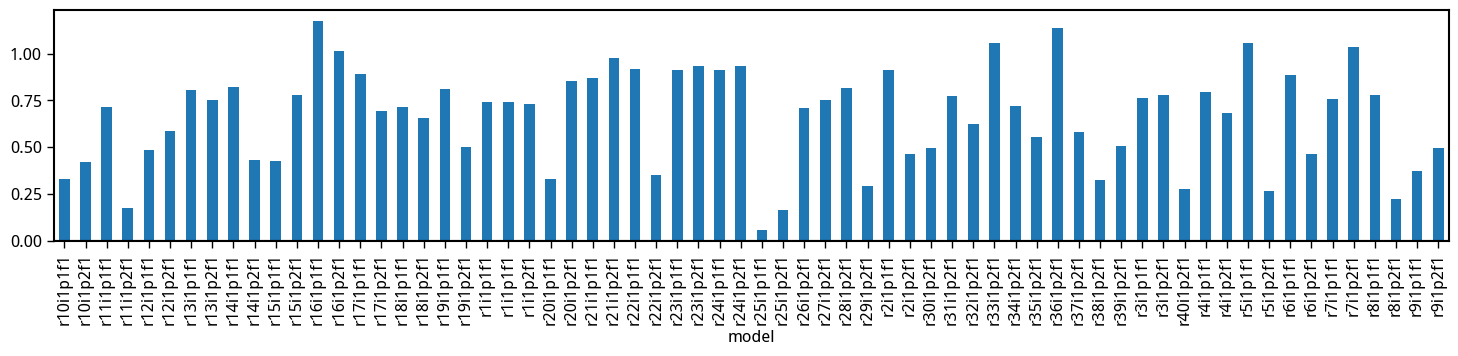

In [33]:
plt.figure(figsize=(18,3))
out_canesm5_le.lnc.isel(season=0, region=41).to_series().plot.bar()#.to_dataframe().pivot_table(values='asymm', columns='model', index='region'), cmap='BrBG')
plt.xticks(rotation=90)
# plt.ylim(-0.5, 0.5)
plt.axhline(0.0, color='k')

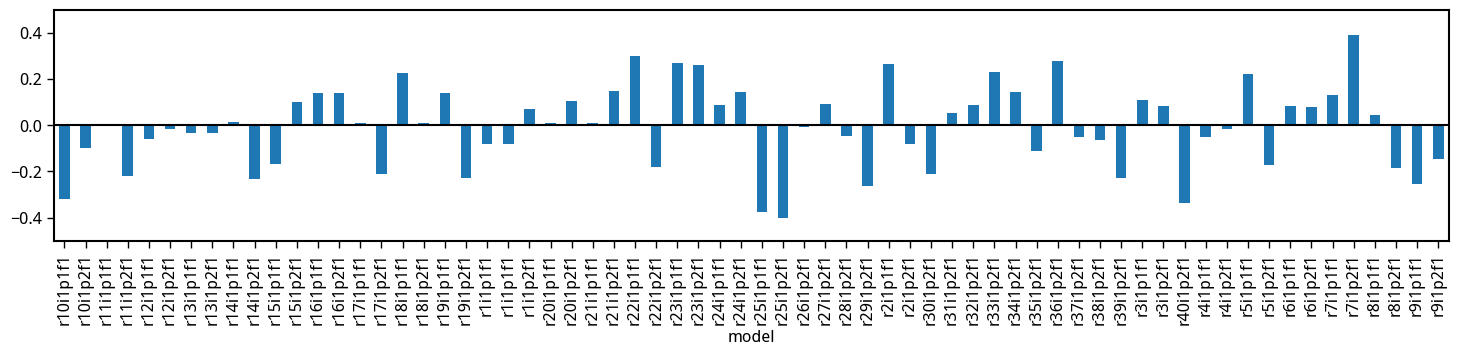

In [34]:
plt.figure(figsize=(18,3))
out_canesm5_le.asymm.isel(season=0, region=41).to_series().plot.bar()#.to_dataframe().pivot_table(values='asymm', columns='model', index='region'), cmap='BrBG')
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5)
plt.axhline(0.0, color='k')


Text(0, 0.5, 'asymm uncertainty ($\\sigma$)')

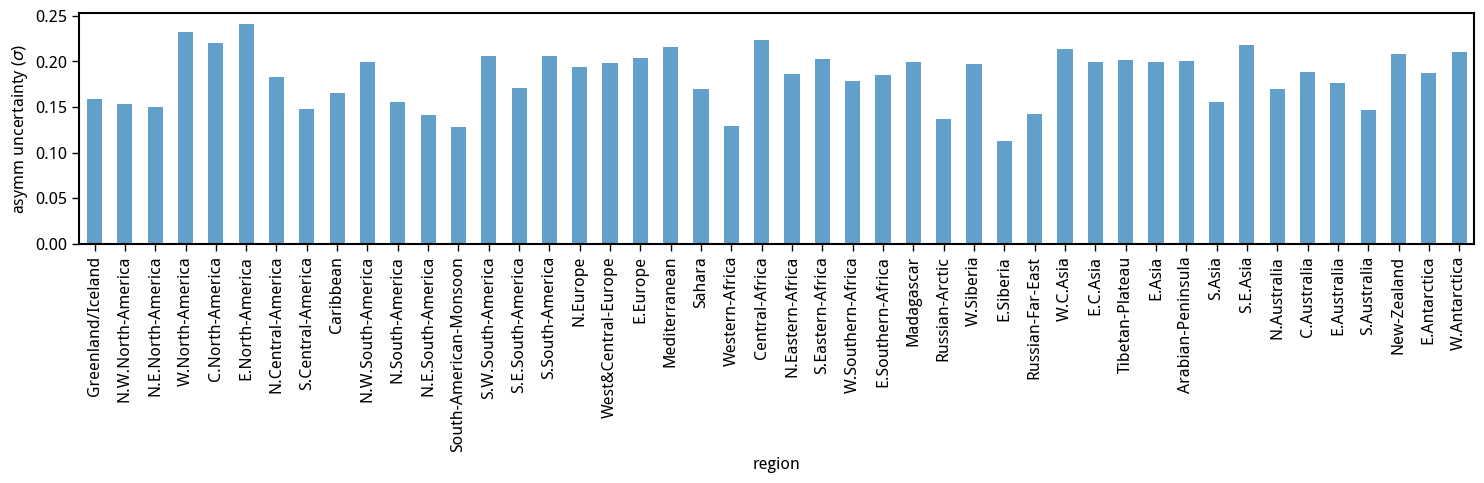

In [35]:
plt.figure(figsize=(18,3))
out_canesm5_le.asymm.isel(season=0).std(dim='model').to_series().plot.bar(alpha=0.7)#.to_dataframe().pivot_table(values='asymm', columns='model', index='region'), cmap='BrBG')
plt.xticks(rotation=90)
# plt.ylim(-0.5, 0.5)
# plt.axhline(0.0, color='k')
plt.ylabel('asymm uncertainty ($\sigma$)')

PearsonRResult(statistic=0.39023628959584844, pvalue=0.0011987312897333543)

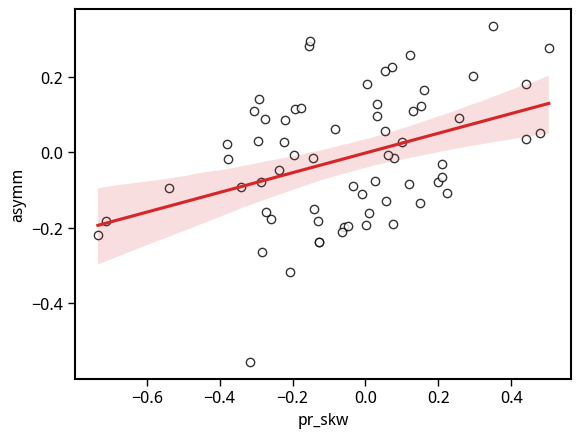

In [36]:
sns.regplot(x = out_canesm5_le.pr_skw.isel(season=0, region=39), y = out_canesm5_le.asymm.isel(season=0, region=39), marker='o', color='k', scatter_kws=dict(facecolor='white'), line_kws=dict(color='tab:red'))
stats.pearsonr(out_canesm5_le.pr_skw.isel(season=0, region=39), out_canesm5_le.asymm.isel(season=0, region=39))